# Scripts 
Ce notebook présente un script de traitement d'images hébergés sur un serveur S3 d'AWS.
## Chargement des bibliothèques

In [1]:
import boto3
import cv2
import os
import numpy as np
import pandas as pd
from PIL import Image
from io import BytesIO
import findspark
findspark.init()
import pyspark
from pyspark.sql import SparkSession

## Connexion au serveur S3 contenant les images

In [2]:
#clefs d'accès
acces_key ='XXXXXXXXXXXXXXXX'
secret_acces_key = 'XXXXXXXXXXXXXXXX'

In [3]:
#connexion au serveur
s3 = boto3.resource(
    service_name='s3',
    region_name='eu-west-3',
    aws_access_key_id=acces_key,
    aws_secret_access_key=secret_acces_key
)

## Initialisation de la session Spark

In [4]:
spark = (SparkSession
             .builder.master('local[*]')
             .appName('p8')
             .config('spark.executor.memory', '16g')
             .config('spark.driver.memory', '16g') 
             .getOrCreate()
            )

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
21/12/22 13:54:43 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
spark

## Test de connexion au serveur S3 & affichage d'une image

In [6]:
test = s3.Bucket('bp8').Object('Data/Orange/0_100.jpg').get().get('Body').read()

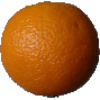

In [7]:
img = Image.open(BytesIO(test))
img

## Extraction de features
### Chargement des bibliothèquess pour l'extraction de features

In [8]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16
from keras.models import Model

2021-12-22 13:54:48.544439: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ec2-user/anaconda3/lib/python3.9/site-packages/cv2/../../lib64:
2021-12-22 13:54:48.544478: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Initialisation du model VGG16 en Transfer Learning

In [9]:
# chargement du modèle
model = VGG16()
# retrait de la couche de sortie pour utiliser le modèle en Transfer Learning
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

2021-12-22 13:54:52.947410: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ec2-user/anaconda3/lib/python3.9/site-packages/cv2/../../lib64:
2021-12-22 13:54:52.947449: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-22 13:54:52.947480: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-31-16-246.eu-west-3.compute.internal): /proc/driver/nvidia/version does not exist
2021-12-22 13:54:52.947761: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compile

### Extraction de features des images contenus dans le serveur S3

In [10]:
#création d'un dataframe vide qui contiendras les résultats
df = pd.DataFrame(columns=['nom_photos','nom_fruit','features'])

#boucle qui parcours les images présents dans le Bucket 'bp8'
for obj in s3.Bucket('bp8').objects.all():
    #lecture de l'image
    img = s3.Bucket('bp8').Object(obj.key).get().get('Body').read()
    img = Image.open(BytesIO(img))
    #redimensionner l'image pour le modèle VGG16
    img = img.resize([224, 224])
    #conversion de l'image en array
    img = img_to_array(img)
    #conversion des dimensions de l'array pour le modèle
    img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
    #preprocessing de l'image pour le modèle
    img = preprocess_input(img)
    #extraction des features
    features = model.predict(img)
    #transformer l'array de features en liste 
    feats = features.ravel().tolist()
    
    #on écrit une ligne avec le nom de la photos, le nom du fruit et les features extraites
    row={'nom_photos':obj.key,'nom_fruit':obj.key.split('/')[1],'features':feats}
    #on ajoute la ligne au dataframe de résultats
    df=df.append(row, ignore_index=True)

In [11]:
df

,nom_photos,nom_fruit,features
0,Data/Orange/0_100.jpg,Orange,"[0.0, 0.0, 0.0, 1.9661880731582642, 0.0, 0.0, ..."
1,Data/Orange/1_100.jpg,Orange,"[0.0, 0.0, 0.0, 1.9418317079544067, 0.0, 0.0, ..."
2,Data/Orange/2_100.jpg,Orange,"[0.0, 0.0, 0.0, 1.9767392873764038, 0.0, 0.0, ..."
3,Data/Pear/0_100.jpg,Pear,"[0.0, 0.0, 0.0, 2.268749475479126, 0.0, 0.0, 0..."
4,Data/Pear/1_100.jpg,Pear,"[0.0, 0.0, 0.0, 3.191234588623047, 0.0, 0.0, 1..."
5,Data/Pear/2_100.jpg,Pear,"[0.0, 0.0, 0.0, 2.4601657390594482, 0.0, 0.0, ..."
6,Data/Raspberry/0_100.jpg,Raspberry,"[0.0, 0.0, 0.0, 1.9516667127609253, 0.76340484..."
7,Data/Raspberry/1_100.jpg,Raspberry,"[0.0, 0.0, 0.0, 2.4279325008392334, 0.13685750..."
8,Data/Raspberry/2_100.jpg,Raspberry,"[0.0, 0.0, 0.0, 2.304990530014038, 0.142278671..."
9,Data/Strawberry/0_100.jpg,Strawberry,"[0.0, 3.0220353603363037, 0.0, 0.0, 1.05480527..."


In [12]:
len(df['features'][0])

4096

Le modèle VGG16 extrait 4096 features pour chaques images.

### Transformation du Dataframe Pandas des résultats en Dataframe Spark

In [13]:
sdf = spark.createDataFrame(df)
sdf

DataFrame[nom_photos: string, nom_fruit: string, features: array<double>]

In [14]:
sdf.show()

+--------------------+----------+--------------------+
|          nom_photos| nom_fruit|            features|
+--------------------+----------+--------------------+
|Data/Orange/0_100...|    Orange|[0.0, 0.0, 0.0, 1...|
|Data/Orange/1_100...|    Orange|[0.0, 0.0, 0.0, 1...|
|Data/Orange/2_100...|    Orange|[0.0, 0.0, 0.0, 1...|
| Data/Pear/0_100.jpg|      Pear|[0.0, 0.0, 0.0, 2...|
| Data/Pear/1_100.jpg|      Pear|[0.0, 0.0, 0.0, 3...|
| Data/Pear/2_100.jpg|      Pear|[0.0, 0.0, 0.0, 2...|
|Data/Raspberry/0_...| Raspberry|[0.0, 0.0, 0.0, 1...|
|Data/Raspberry/1_...| Raspberry|[0.0, 0.0, 0.0, 2...|
|Data/Raspberry/2_...| Raspberry|[0.0, 0.0, 0.0, 2...|
|Data/Strawberry/0...|Strawberry|[0.0, 3.022035360...|
|Data/Strawberry/1...|Strawberry|[0.0, 2.805222988...|
|Data/Strawberry/2...|Strawberry|[0.0, 2.166394233...|
|Data/Watermelon/0...|Watermelon|[0.0, 1.022060632...|
|Data/Watermelon/1...|Watermelon|[0.0, 0.263160854...|
|Data/Watermelon/2...|Watermelon|[0.0, 1.193872451...|
+---------

## Preprocessing
### Importation des bibliothèques pour le preprocessing

In [15]:
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.sql.functions import udf
from pyspark.ml.linalg import Vectors, VectorUDT

### Vectorisation de la colonne des features pour traitements avec Spark

In [16]:
to_vector = udf(lambda x: Vectors.dense(x), VectorUDT())
sdf_vect = sdf.select('nom_photos', 'nom_fruit', 
                      to_vector('features').alias('features_vect'))
sdf_vect.show()

+--------------------+----------+--------------------+
|          nom_photos| nom_fruit|       features_vect|
+--------------------+----------+--------------------+
|Data/Orange/0_100...|    Orange|[0.0,0.0,0.0,1.96...|
|Data/Orange/1_100...|    Orange|[0.0,0.0,0.0,1.94...|
|Data/Orange/2_100...|    Orange|[0.0,0.0,0.0,1.97...|
| Data/Pear/0_100.jpg|      Pear|[0.0,0.0,0.0,2.26...|
| Data/Pear/1_100.jpg|      Pear|[0.0,0.0,0.0,3.19...|
| Data/Pear/2_100.jpg|      Pear|[0.0,0.0,0.0,2.46...|
|Data/Raspberry/0_...| Raspberry|[0.0,0.0,0.0,1.95...|
|Data/Raspberry/1_...| Raspberry|[0.0,0.0,0.0,2.42...|
|Data/Raspberry/2_...| Raspberry|[0.0,0.0,0.0,2.30...|
|Data/Strawberry/0...|Strawberry|[0.0,3.0220353603...|
|Data/Strawberry/1...|Strawberry|[0.0,2.8052229881...|
|Data/Strawberry/2...|Strawberry|[0.0,2.1663942337...|
|Data/Watermelon/0...|Watermelon|[0.0,1.0220606327...|
|Data/Watermelon/1...|Watermelon|[0.0,0.2631608545...|
|Data/Watermelon/2...|Watermelon|[0.0,1.1938724517...|
+---------

### Normalisation des features avec StandardScaler

In [17]:
scaler = StandardScaler(withMean=True, withStd=True,inputCol="features_vect",outputCol="features_scaled")

In [18]:
sdf_scaled=scaler.fit(sdf_vect).transform(sdf_vect)

In [19]:
sdf_scaled.show()

+--------------------+----------+--------------------+--------------------+
|          nom_photos| nom_fruit|       features_vect|     features_scaled|
+--------------------+----------+--------------------+--------------------+
|Data/Orange/0_100...|    Orange|[0.0,0.0,0.0,1.96...|[0.0,-0.635039334...|
|Data/Orange/1_100...|    Orange|[0.0,0.0,0.0,1.94...|[0.0,-0.635039334...|
|Data/Orange/2_100...|    Orange|[0.0,0.0,0.0,1.97...|[0.0,-0.635039334...|
| Data/Pear/0_100.jpg|      Pear|[0.0,0.0,0.0,2.26...|[0.0,-0.635039334...|
| Data/Pear/1_100.jpg|      Pear|[0.0,0.0,0.0,3.19...|[0.0,-0.635039334...|
| Data/Pear/2_100.jpg|      Pear|[0.0,0.0,0.0,2.46...|[0.0,-0.635039334...|
|Data/Raspberry/0_...| Raspberry|[0.0,0.0,0.0,1.95...|[0.0,-0.635039334...|
|Data/Raspberry/1_...| Raspberry|[0.0,0.0,0.0,2.42...|[0.0,-0.635039334...|
|Data/Raspberry/2_...| Raspberry|[0.0,0.0,0.0,2.30...|[0.0,-0.635039334...|
|Data/Strawberry/0...|Strawberry|[0.0,3.0220353603...|[0.0,2.1136827719...|
|Data/Strawb

In [20]:
sdf_scaled = sdf_scaled.select('nom_photos','nom_fruit','features_scaled')

In [21]:
sdf_scaled.show()

+--------------------+----------+--------------------+
|          nom_photos| nom_fruit|     features_scaled|
+--------------------+----------+--------------------+
|Data/Orange/0_100...|    Orange|[0.0,-0.635039334...|
|Data/Orange/1_100...|    Orange|[0.0,-0.635039334...|
|Data/Orange/2_100...|    Orange|[0.0,-0.635039334...|
| Data/Pear/0_100.jpg|      Pear|[0.0,-0.635039334...|
| Data/Pear/1_100.jpg|      Pear|[0.0,-0.635039334...|
| Data/Pear/2_100.jpg|      Pear|[0.0,-0.635039334...|
|Data/Raspberry/0_...| Raspberry|[0.0,-0.635039334...|
|Data/Raspberry/1_...| Raspberry|[0.0,-0.635039334...|
|Data/Raspberry/2_...| Raspberry|[0.0,-0.635039334...|
|Data/Strawberry/0...|Strawberry|[0.0,2.1136827719...|
|Data/Strawberry/1...|Strawberry|[0.0,1.9164789375...|
|Data/Strawberry/2...|Strawberry|[0.0,1.3354259350...|
|Data/Watermelon/0...|Watermelon|[0.0,0.2945860071...|
|Data/Watermelon/1...|Watermelon|[0.0,-0.395678780...|
|Data/Watermelon/2...|Watermelon|[0.0,0.4508591439...|
+---------

## Réduction de dimension : ACP
### ACP sur l'ensemble des features

In [22]:
from pyspark.ml.feature import PCA
acp = PCA(k=4096, inputCol="features_scaled",outputCol="features_reduc")

In [23]:
acp = acp.fit(sdf_scaled)

21/12/22 13:55:17 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
21/12/22 13:55:17 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
21/12/22 13:55:20 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
21/12/22 13:55:20 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


In [24]:
sdf_acp = acp.transform(sdf_scaled)

In [25]:
sdf_acp.show()

21/12/22 13:58:29 WARN DAGScheduler: Broadcasting large task binary with size 128.1 MiB
21/12/22 13:58:31 WARN DAGScheduler: Broadcasting large task binary with size 128.1 MiB


+--------------------+----------+--------------------+--------------------+
|          nom_photos| nom_fruit|     features_scaled|      features_reduc|
+--------------------+----------+--------------------+--------------------+
|Data/Orange/0_100...|    Orange|[0.0,-0.635039334...|[-20.760560187836...|
|Data/Orange/1_100...|    Orange|[0.0,-0.635039334...|[-22.357240872551...|
|Data/Orange/2_100...|    Orange|[0.0,-0.635039334...|[-21.857788328993...|
| Data/Pear/0_100.jpg|      Pear|[0.0,-0.635039334...|[-15.217432775581...|
| Data/Pear/1_100.jpg|      Pear|[0.0,-0.635039334...|[-16.211780407815...|
| Data/Pear/2_100.jpg|      Pear|[0.0,-0.635039334...|[-15.093371560765...|
|Data/Raspberry/0_...| Raspberry|[0.0,-0.635039334...|[49.5407540337741...|
|Data/Raspberry/1_...| Raspberry|[0.0,-0.635039334...|[47.4058058854745...|
|Data/Raspberry/2_...| Raspberry|[0.0,-0.635039334...|[43.9631149626791...|
|Data/Strawberry/0...|Strawberry|[0.0,2.1136827719...|[-14.485038793318...|
|Data/Strawb

### Extraction de la variance expliquée

In [26]:
var = acp.explainedVariance.cumsum()

In [27]:
eigval = var.ravel().tolist()

In [28]:
import matplotlib.pyplot as plt

In [41]:
eigval = pd.DataFrame(var.ravel().tolist())

### Recherche du nombre de dimensions optimal

In [40]:
eigval[eigval[0]<0.9999].T

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.281871,0.539335,0.722124,0.871947,0.902716,0.919527,0.934928,0.949578,0.961136,0.97076,0.979967,0.987471,0.994271


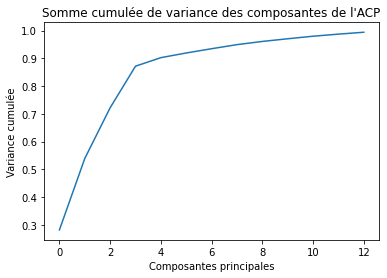

In [42]:
plt.plot(eigval[eigval[0]<0.9999])
plt.title("Somme cumulée de variance des composantes de l'ACP")
plt.xlabel('Composantes principales')
plt.ylabel('Variance cumulée')
plt.show()

Méthode du coude : Sélection de 4 dimensions pour 87% de variance expliquée.

### ACP à 4 dimensions 

In [33]:
acp_2 = PCA(k=4, inputCol="features_scaled",outputCol="features_reduc")

In [34]:
acp_2 = acp_2.fit(sdf_scaled)

In [35]:
sdf_acp_2 = acp_2.transform(sdf_scaled)

In [39]:
sdf_acp_2.select('nom_photos','nom_fruit','features_reduc').show()

+--------------------+----------+--------------------+
|          nom_photos| nom_fruit|      features_reduc|
+--------------------+----------+--------------------+
|Data/Orange/0_100...|    Orange|[-20.760560187836...|
|Data/Orange/1_100...|    Orange|[-22.357240872551...|
|Data/Orange/2_100...|    Orange|[-21.857788328993...|
| Data/Pear/0_100.jpg|      Pear|[-15.217432775581...|
| Data/Pear/1_100.jpg|      Pear|[-16.211780407815...|
| Data/Pear/2_100.jpg|      Pear|[-15.093371560765...|
|Data/Raspberry/0_...| Raspberry|[49.5407540337741...|
|Data/Raspberry/1_...| Raspberry|[47.4058058854745...|
|Data/Raspberry/2_...| Raspberry|[43.9631149626791...|
|Data/Strawberry/0...|Strawberry|[-14.485038793318...|
|Data/Strawberry/1...|Strawberry|[-13.951021078570...|
|Data/Strawberry/2...|Strawberry|[-13.916918601025...|
|Data/Watermelon/0...|Watermelon|[4.27065588757065...|
|Data/Watermelon/1...|Watermelon|[4.80215719163963...|
|Data/Watermelon/2...|Watermelon|[3.86866464532147...|
+---------

## Récupération des features après réduction de dimension & extraction en .CSV

In [37]:
res_acp = sdf_acp_2.select('nom_photos','nom_fruit','features_reduc')
res_acp = res_acp.toPandas()

In [38]:
res_acp

,nom_photos,nom_fruit,features_reduc
0,Data/Orange/0_100.jpg,Orange,"[-20.760560187836987, 10.195304327833885, 24.7..."
1,Data/Orange/1_100.jpg,Orange,"[-22.357240872551145, 10.497959819930811, 26.8..."
2,Data/Orange/2_100.jpg,Orange,"[-21.857788328993784, 11.376750553523568, 25.3..."
3,Data/Pear/0_100.jpg,Pear,"[-15.217432775581614, -8.6397438248207, 11.328..."
4,Data/Pear/1_100.jpg,Pear,"[-16.21178040781596, -8.357983716988645, 11.96..."
5,Data/Pear/2_100.jpg,Pear,"[-15.093371560765394, -9.257572494458866, 12.2..."
6,Data/Raspberry/0_100.jpg,Raspberry,"[49.54075403377412, 15.177776383192334, 8.0730..."
7,Data/Raspberry/1_100.jpg,Raspberry,"[47.405805885474585, 12.983429347905266, 7.624..."
8,Data/Raspberry/2_100.jpg,Raspberry,"[43.96311496267919, 13.343861394331869, 6.6168..."
9,Data/Strawberry/0_100.jpg,Strawberry,"[-14.48503879331866, 27.6418428243225, -32.910..."


In [48]:
res_acp.to_csv('resultats_acp.csv', index = False)

## Upload sur serveur S3

In [50]:
s3.meta.client.upload_file('resultats_acp.csv', 'bp8','resultats_acp.csv')